## Gameplan
1. Load IMDb Movie Reviews dataset:
   - Read the IMDb dataset into your Python environment using a suitable method.
2. Pre-process dataset:
   - Clean the text data by removing any special characters, numbers, or unnecessary elements from the movie reviews. You can use regular expressions or string manipulation techniques for this task.
   - Convert the sentiment labels from positive and negative to numerical values, such as 1 and 0, respectively.

3. Import GloVe Word Embedding:
   - Download the pre-trained GloVe word embeddings. GloVe provides word vectors that capture semantic meanings of words based on large-scale text data.
   - Load the GloVe word embeddings into my Python environment. The embeddings are available in different dimensions, so choose the appropriate dimension based on your requirements.

4. Build Embedding Dictionary and Embedding Matrix:
   - Create an embedding dictionary that maps each word in my corpus to its corresponding word vector in the GloVe embeddings.
   - Construct an embedding matrix using the embedding dictionary. The embedding matrix will be used as the initial weights for the embedding layer in my model.

5. Model Training:
   - Split the pre-processed dataset into training and testing sets using the `train_test_split` function from scikit-learn.
   - Build and train model for LSTM architecture using Keras. The models can utilize the pre-trained word embeddings from the GloVe embeddings.
   - Evaluate the performance of my model using appropriate evaluation metrics.

6. Predict on real IMDb movie reviews:


In [1]:
#Importing essential libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Activation, Dropout, Dense
from sklearn.model_selection import train_test_split

2023-07-12 02:13:36.099212: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 02:13:39.757397: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-12 02:13:46.779796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Dataset

In [2]:
reviews = pd.read_csv("/home/asomba/Downloads/IMDB Dataset.csv")

In [3]:
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
reviews.isnull().values.any()
#checks for missing values

False

<Axes: xlabel='sentiment', ylabel='count'>

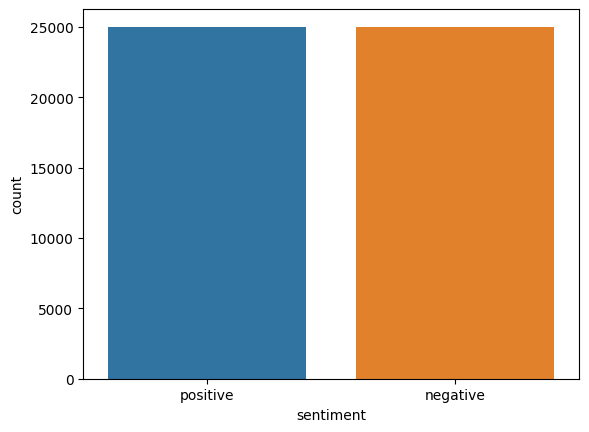

In [5]:
import seaborn as sns
sns.countplot(x='sentiment', data=reviews)
#Check distribution of negative and positive sentiments

## Preprocessing the data

In [6]:
reviews["review"][8]
#text contains punctuations, brackets, HTML tags and numbers 

"Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."

In [7]:
rm_tag = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return rm_tag.sub('', text)

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/asomba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def preprocess_text(sen):
    '''The text data is filtered to remove long words from the dataset. Only words with a length below a certain threshold are kept, while shorter words are retained. This helps to simplify the dataset and focus on more relevant and meaningful words.'''
   
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # remove single character 
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [10]:
X = []
sentences = list(reviews['review'])
for sen in sentences:
   X.append(preprocess_text(sen))
#Called preprocess function on reviews

In [11]:
X[5]
#preprocessed movie review
# I did'nt perform stemming/lemmatization because I'd be using word embeddings

'probably time favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years paul lukas performance brings tears eyes bette davis one truly sympathetic roles delight kids grandma says like dressed midgets children makes fun watch mother slow awakening happening world roof believable startling dozen thumbs movie '

In [12]:
y = reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))
# Replacing sentiment label with 0&1

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# I'll use the test set to evaluate how well the model performs and the train set to build my deep learnng model

## Preparing embedding layer

In [14]:
# Embedding layer expects the words to be in numeric form 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [15]:
vocab_length = len(word_tokenizer.word_index) + 1
#added 1 for words which no pretrained embedding exist

vocab_length

92394

In [16]:
max_len = 100

X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)
#padded all reviews to a length of 100

In [17]:

#!unzip glove.6B.zip


In [18]:
# Load GloVe word embeddings and create an Embeddings Dictionary
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()


In [19]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [71]:
embedding_matrix.shape

(92394, 100)

In [72]:
from keras.layers import LSTM

In [73]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [74]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [75]:
#lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [76]:
#score = lstm_model.evaluate(X_test, y_test, verbose=1)

In [77]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

NameError: name 'score' is not defined

In [ ]:
# Model Performance viz

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:

#lstm_model.save(f"./review_sentiment{round(score[1], 3)}.h5", save_format='h5')

In [ ]:
ls

## Testing the model with real world data

In [20]:
from keras.models import load_model
from tensorflow import keras

In [22]:
import requests
from bs4 import BeautifulSoup
import re
from transformers import AutoTokenizer

In [31]:
r = requests.get('https://www.yelp.com/biz/social-brew-cafe-pyrmont')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class':regex})
reviews = [result.text for result in results]

In [32]:
reviews

[]

In [25]:
import numpy as np
import pandas as pd

In [155]:
test_rev= pd.DataFrame(np.array(reviews), columns=['review'])


In [156]:
model = load_model("lstm_model.h5")

In [157]:
test_rev

,review
0,Some of the best Milkshakes me and my daughter...
1,Great place with delicious food and friendly s...
2,Great food amazing coffee and tea. Short walk ...
3,It was ok. Had coffee with my friends. I'm new...
4,Ricotta hot cakes! These were so yummy. I ate ...
5,Great staff and food. Must try is the pan fri...
6,We came for brunch twice in our week-long visi...
7,I came to Social brew cafe for brunch while ex...
8,It was ok. The coffee wasn't the best but it w...
9,Great coffee and vibe. That's all you need. C...


In [158]:
unseen_reviews

0    I got tired pulling all the broken glass and g...
1    Love the customer service, very speedy service...
2    Avoid this shop. I dropped off my device for r...
3    My cell phone screen is cracked and this is th...
4    Referred by insurance company called "assuranc...
Name: review, dtype: object

In [159]:
unseen_reviews = test_rev['review']

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [160]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=max_len)

In [161]:
unseen_sentiments = model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 682ms/step


array([[0.79375285],
       [0.9787259 ],
       [0.97999513],
       [0.7349085 ],
       [0.53456455],
       [0.7823258 ],
       [0.6581744 ],
       [0.5936432 ],
       [0.6634662 ],
       [0.9758505 ],
       [0.7933274 ]], dtype=float32)

In [33]:
# Mapping function to convert sentiment scores to labels
def map_sentiment(score):
    if score >= 5:
        return "positive"
    else:
        return "negative"

# Apply the mapping function to convert sentiment scores to labels
df_prediction_sentiments = pd.DataFrame(test_rev['Predicted Sentiments'], columns=['Predicted Sentiments'])
df_prediction_sentiments['Sentiment Label'] = df_prediction_sentiments['Predicted Sentiments'].apply(map_sentiment)

# Create dataframe for review text
df_review_text = pd.DataFrame(test_rev['review'], columns=['Review Text'])

# Combine the dataframes
dfx = pd.concat([df_review_text, df_prediction_sentiments], axis=1)

# Save to a CSV file
dfx.to_csv("analysed_sentiment_1.csv", sep=',', encoding='UTF-8', index=False)

# Display the first 6 rows of the dataframe
dfx.head(6)


NameError: name 'test_rev' is not defined

In [ ]:
dfx["Sentiment Label"]=="negative"